In [6]:
import sys
from pathlib import Path

# Add repo root to sys.path FIRST so local trace package takes precedence
repo_root = Path("/Users/rjm707/Desktop/trace_paper")
if str(repo_root) not in sys.path:
    sys.path.insert(0, str(repo_root))

# Now import from local trace package
from trace.statistics import logit, inv_logit
import polars as pl

df = pl.read_csv("../data/semaglutide-atc_RR_CI_table.csv").sort("outcome").filter(
    pl.col("outcome") != "A10BJ"
).filter(
    ~pl.col("outcome").str.starts_with("V")
)

In [7]:
tab = pl.read_csv("../data/semaglutide-atc_table.csv", columns=["outcome", "treated_prevalence"])
df = df.join(tab, on="outcome")

In [8]:
atc_dict = pl.read_csv('../helper_data/atc_dict_en.csv', separator=";")
atc_dict = {atc[1:]: text.capitalize() for atc, text in zip(atc_dict['Code'], atc_dict['Text'])}

# Overall forest plan

/var/folders/t8/0k1yc0g54t5c5g_kn7tj10mw0000gn/T/ipykernel_1166/3694914005.py:40: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


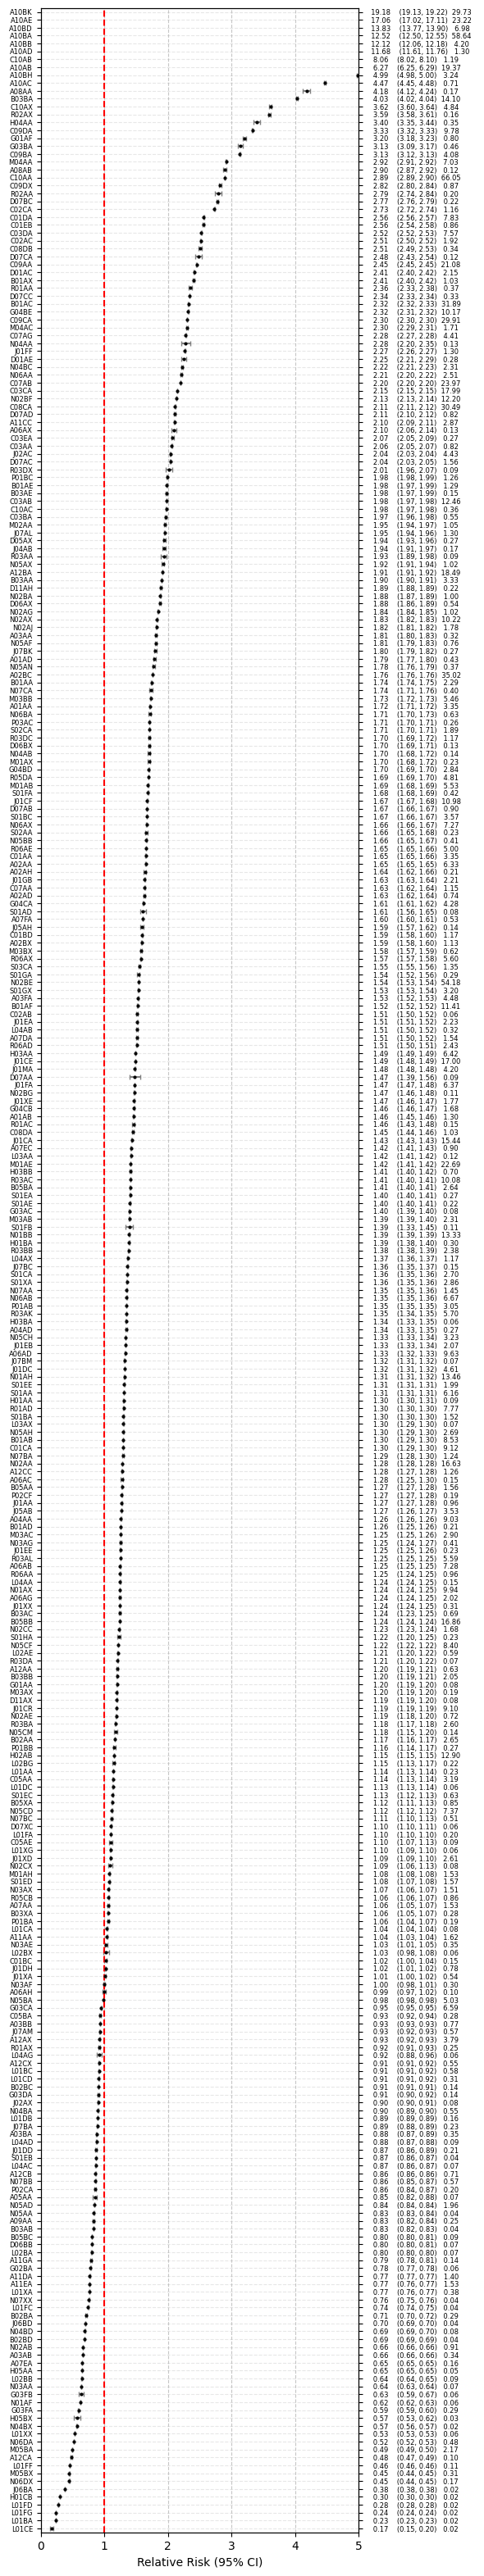

In [9]:
import matplotlib.pyplot as plt
import numpy as np


fig, ax = plt.subplots(figsize=(5, 40))
fig.subplots_adjust(wspace=0.8)
df = df.sort("RR_mean", descending=True)
studies = df["outcome"]
estimates = df["RR_mean"]
ci_lower = df["CI_low"]
ci_upper = df["CI_high"]
prevalence = df["treated_prevalence"]

est = estimates.to_numpy()
ci_l = ci_lower.to_numpy()
ci_u = ci_upper.to_numpy()
stud = studies.to_numpy()
prev = prevalence.to_numpy()


y = np.arange(len(est))
ax.errorbar(est, y, xerr=[est - ci_l, ci_u - est],
        fmt='o', color='black', ecolor='gray', capsize=2, markersize=2)
ax.set_yticks(y)
ax.set_yticklabels(stud, fontdict={'fontsize': 6})
ax.axvline(x=1, color='red', linestyle='--')
ax.set_xlim(0, 5)
ax.set_ylim(-0.5, len(est)-0.5)
ax.invert_yaxis()  # studies top-down
ax.set_xlabel("Relative Risk (95% CI)")
ax.grid(True, axis='x', linestyle='--', alpha=0.7)
ax.grid(True, axis="y", linestyle='--', alpha=0.3)

ax2 = ax.twinx()  # create a twin that shares the same x-axis
ax2.set_ylim(ax.get_ylim())  # sync y-limits
ax2.set_yticks(y)

txt = [f"{e:^10.2f} ({cl:>4.2f}, {ch:<4.2f}) {p*100:^8.2f}" for e, cl, ch, p in zip(est, ci_l, ci_u, prev)]
ax2.set_yticklabels(txt, fontdict={'fontsize': 6})
fig.show()

# Filtered Forest plot per Group

In [10]:
# special_atc = [["A10"], ["C02", "C07", "C08", "C09"], ["G04BE"], ["N06A"], ["H03AA"], ["B01AF"], ["R0"], ["A02"], ["J01", "P01AB01"], ["N02BF"]]
special_atc = [["N06D"], ["M05B"], ["G04BE"], ["N06A"], ["A02"], ["N02BF"]]
# special_atc.pop(0)
special__atc = sum(special_atc, [])  # flatten list of lists

In [11]:
filtered = df.filter(
    pl.any_horizontal(
        pl.col("outcome").str.starts_with(atc) for atc in special__atc
    )
)

In [12]:
N_group = []
for atc_group in special_atc:
    N = filtered.filter(
        pl.any_horizontal(
            pl.col("outcome").str.starts_with(atc) for atc in atc_group
        )
    ).height
    N_group.append(N)


/var/folders/t8/0k1yc0g54t5c5g_kn7tj10mw0000gn/T/ipykernel_1166/2609200060.py:49: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


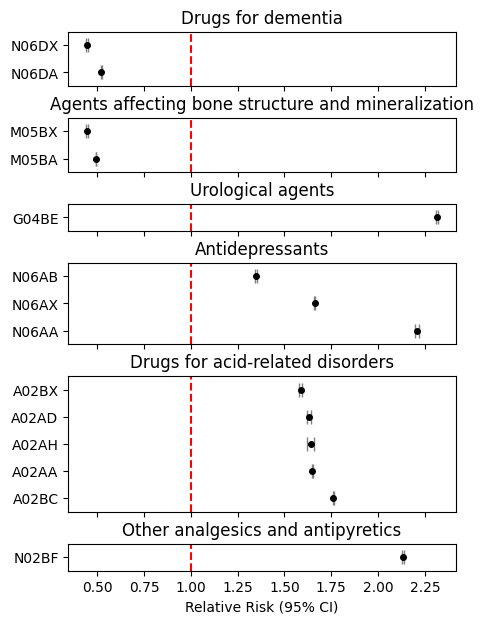

In [13]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import numpy as np

fig = plt.figure(figsize=(5, sum(N_group) * 0.5))
gs = gridspec.GridSpec(len(N_group), 1, height_ratios=N_group, figure=fig)

atc3_groups = ["N06D", "M05B", "G04B", "N06A", "A02", "N02B"]
atc3_groups = [atc_dict[g] for g in atc3_groups]

base_ax = fig.add_subplot(111, frameon=False)
base_ax.set_visible(False)
axes = [
    fig.add_subplot(gs[i], sharex=base_ax)
    for i in range(len(N_group))]

for i, ax in enumerate(axes):
    atc_group = special_atc[i]
    group_filtered = df.filter(
        pl.any_horizontal(
            pl.col("outcome").str.starts_with(atc) for atc in atc_group
        )
    )

    # Example data
    studies = group_filtered["outcome"]
    estimates = group_filtered["RR_mean"]
    ci_lower = group_filtered["CI_low"]
    ci_upper = group_filtered["CI_high"]

    y = np.arange(len(studies))

    ax.errorbar(estimates, y, xerr=[estimates - ci_lower, ci_upper - estimates],
                 fmt='o', color='black', ecolor='gray', capsize=5, markersize=4)

    ax.axvline(1, color='red', linestyle='--', ymin=0, ymax=len(studies))  # reference line
    ax.set_yticks(y)
    ax.set_yticklabels(studies)
    ax.invert_yaxis()  # studies top-down
    ax.label_outer()               # hide x tick labels except on bottom axis
    ax.set_ylim(-0.5, len(studies)-0.5)
    ax.set_title(f"{atc3_groups[i]}")



fig.subplots_adjust(hspace=0.5)
ax.set_xlabel("Relative Risk (95% CI)")
fig.show()

Text(0.5, 0, 'Relative Risk (95% CI)')

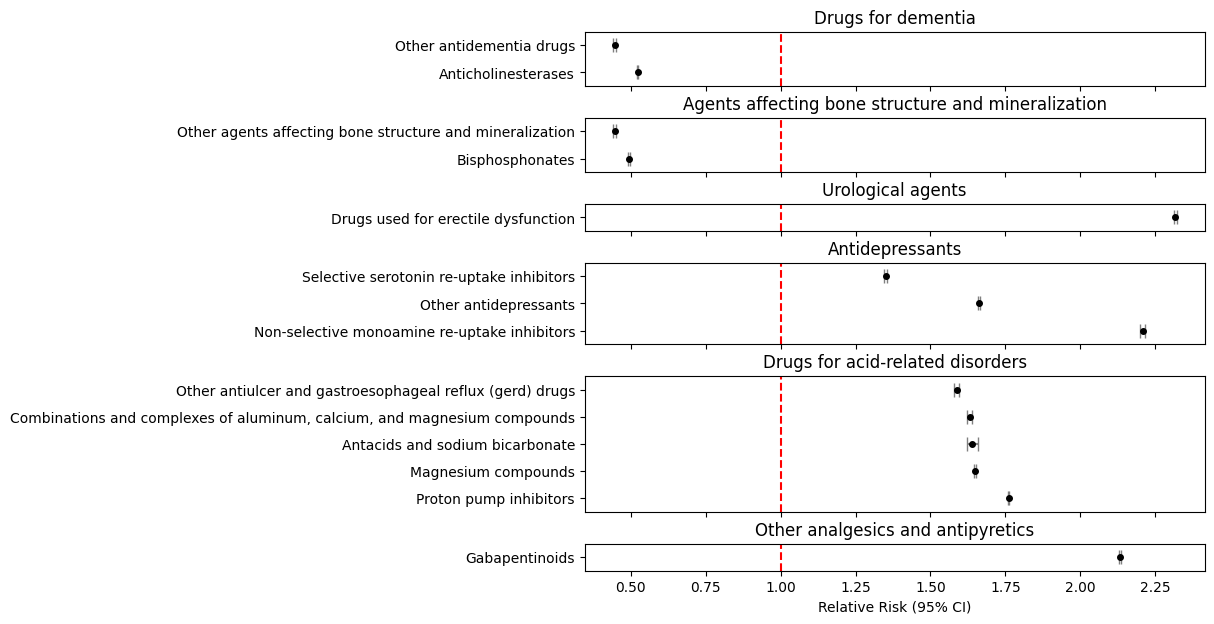

In [14]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import numpy as np

fig = plt.figure(figsize=(8, sum(N_group) * 0.5))
gs = gridspec.GridSpec(len(N_group), 1, height_ratios=N_group, figure=fig)

atc3_groups = ["N06D", "M05B", "G04B", "N06A", "A02", "N02B"]
atc3_groups = [atc_dict[g] for g in atc3_groups]

base_ax = fig.add_subplot(111, frameon=False)
base_ax.set_visible(False)
axes = [
    fig.add_subplot(gs[i], sharex=base_ax)
    for i in range(len(N_group))]

for i, ax in enumerate(axes):
    atc_group = special_atc[i]  # skip "A10"
    group_filtered = df.filter(
        pl.any_horizontal(
            pl.col("outcome").str.starts_with(atc) for atc in atc_group
        )
    )

    # Example data
    studies = group_filtered["outcome"].replace_strict(atc_dict)
    estimates = group_filtered["RR_mean"]
    ci_lower = group_filtered["CI_low"]
    ci_upper = group_filtered["CI_high"]

    y = np.arange(len(studies))

    ax.errorbar(estimates, y, xerr=[estimates - ci_lower, ci_upper - estimates],
                 fmt='o', color='black', ecolor='gray', capsize=5, markersize=4)

    ax.axvline(1, color='red', linestyle='--', ymin=0, ymax=len(studies))  # reference line
    ax.set_yticks(y)
    ax.set_yticklabels(studies)
    ax.invert_yaxis()  # studies top-down
    ax.label_outer()               # hide x tick labels except on bottom axis
    ax.set_ylim(-0.5, len(studies)-0.5)
    ax.set_title(f"{atc3_groups[i]}")


fig.subplots_adjust(hspace=0.5)
ax.set_xlabel("Relative Risk (95% CI)")